<a href="https://colab.research.google.com/github/Eddythemachine/classification_coursera/blob/main/svm_nystroem_comparison_using_gen_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Support Vector Machines (SVMs) are powerful classification algorithms, but they quickly become computationally expensive when working with large datasets or high-dimensional feature spaces. This is especially true when using nonlinear kernels such as the RBF kernel, which require computing the full kernel matrix—an operation that grows quadratically with the number of samples.

To better understand and improve the computational efficiency of SVMs, I am comparing the performance of a standard SVM with the RBF kernel against SVM models that use kernel approximation techniques, specifically the Nyström method. Kernel approximation provides a way to project data into a lower-dimensional feature space where a linear SVM can approximate the behavior of a nonlinear kernel, but with significantly reduced computational cost.

In this experiment, I generate a synthetic dataset, train both the traditional RBF SVM and the Nyström-approximated SVM, and measure the time each method takes to transform the data and fit the model. This allows me to directly compare their training speeds and evaluate how much improvement Nyström approximation offers over the traditional SVM training procedure.

The goal is to determine whether kernel approximation can provide substantial speed-ups while still capturing the performance characteristics of kernel-based SVMs, making it a practical alternative for large-scale machine learning tasks.

# IMPORTING LIBS

In [55]:
# -----------------------------
# Standard Library Imports
# -----------------------------
import os
import time
import shutil
import warnings

warnings.filterwarnings('ignore')

# -----------------------------
# Data Manipulation / Visualization
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Kaggle / External Tools
# -----------------------------
import kagglehub

# -----------------------------
# Scikit-learn Imports
# -----------------------------
# Dataset
from sklearn.datasets import make_classification

# Model Selection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.kernel_approximation import Nystroem

# Models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [18]:
# Download latest version
path = kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")

print("Path to dataset files:", path)

100%|██████████| 187k/187k [00:00<00:00, 41.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gauravtopre/bank-customer-churn-dataset/versions/1


In [19]:
# Define destination
destination = "/content/bank-customer-churn-dataset"

# Copy dataset from KaggleHub cache to working directory
shutil.copytree(path, destination, dirs_exist_ok=True)

print("Files copied to:", destination)


Files copied to: /content/bank-customer-churn-dataset


In [21]:
df = pd.read_csv("bank-customer-churn-dataset/Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [23]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

target_col = "churn"

# Remove churn from numerical columns if it is there
if target_col in num_cols:
    num_cols.remove(target_col)

print(num_cols)
print(cat_cols)

['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
['country', 'gender']


In [41]:
# Scalers
std = StandardScaler()
ord = OrdinalEncoder()

In [42]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [43]:
# Spliting into Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
# Numerical columns
X_train[num_cols] = std.fit_transform(X_train[num_cols])
X_test[num_cols] = std.transform(X_test[num_cols])

# Categorical columns
X_train[cat_cols] = ord.fit_transform(X_train[cat_cols])
X_test[cat_cols] = ord.transform(X_test[cat_cols])

In [45]:
X_train

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
9254,-1.246456,0.356500,0.0,1.0,-0.655786,0.345680,-1.218471,0.808436,0.649203,0.974817,1.367670
1561,1.053811,-0.203898,1.0,1.0,0.294938,-0.348369,0.696838,0.808436,0.649203,0.974817,1.661254
1670,0.366479,-0.961472,2.0,1.0,-1.416365,-0.695393,0.618629,-0.916688,0.649203,-1.025834,-0.252807
6087,0.558077,-0.940717,0.0,0.0,-1.131148,1.386753,0.953212,-0.916688,0.649203,-1.025834,0.915393
6669,1.492630,-1.397337,0.0,1.0,1.625953,1.386753,1.057449,-0.916688,-1.540351,-1.025834,-1.059600
...,...,...,...,...,...,...,...,...,...,...,...
5734,-1.308662,1.207474,0.0,1.0,1.435808,1.039728,-0.102301,-0.916688,0.649203,0.974817,-0.539860
5191,-0.133487,0.314989,0.0,0.0,1.816097,-1.389442,-1.218471,-0.916688,0.649203,0.974817,-1.733882
5390,-1.625965,0.865009,0.0,0.0,-0.085351,-1.389442,-1.218471,2.533560,-1.540351,-1.025834,-0.142765
860,1.628523,0.159323,0.0,1.0,0.390011,1.039728,1.827259,-0.916688,0.649203,-1.025834,-0.050826


In [46]:
%%time
# -------------------------------------------
# 2. Baseline: Normal SVM (RBF Kernel)
# -------------------------------------------
start = time.time()
svm_normal = SVC(kernel="rbf")
svm_normal.fit(X_train, y_train)
normal_svm_time = time.time() - start

CPU times: user 1.68 s, sys: 96.4 ms, total: 1.77 s
Wall time: 1.78 s


In [47]:
%%time
# -------------------------------------------
# 3. Nyström Kernel Approximation + Linear SVM
# -------------------------------------------
# Transform time
start = time.time()
nys = Nystroem(gamma=0.2, n_components=500, random_state=42)
X_train_nys = nys.fit_transform(X_train)
nystroem_time = time.time() - start

CPU times: user 1.13 s, sys: 173 ms, total: 1.3 s
Wall time: 1.06 s


In [48]:
%%time
# Fit linear SVM on the approximated features
start = time.time()
svm_nys = SVC(kernel="linear")
svm_nys.fit(X_train_nys, y_train)
svm_nystroem_fit_time = time.time() - start

CPU times: user 17.5 s, sys: 143 ms, total: 17.7 s
Wall time: 18.5 s


In [49]:
%%time
# -------------------------------------------
# 4. Collect Results in a Table
# -------------------------------------------
results = pd.DataFrame({
    "Method": ["Normal SVM (RBF)", "Nyström + Linear SVM"],
    "Transform Time (s)": ["—", f"{nystroem_time:.4f}"],
    "Fit Time (s)": [f"{normal_svm_time:.4f}", f"{svm_nystroem_fit_time:.4f}"],
    "Total Time (s)": [
        f"{normal_svm_time:.4f}",
        f"{(nystroem_time + svm_nystroem_fit_time):.4f}"
    ]
})


CPU times: user 797 µs, sys: 0 ns, total: 797 µs
Wall time: 805 µs


In [50]:
print("\n=== SPEED COMPARISON ===")
print(results)


=== SPEED COMPARISON ===
                 Method Transform Time (s) Fit Time (s) Total Time (s)
0      Normal SVM (RBF)                  —       1.7792         1.7792
1  Nyström + Linear SVM             1.0571      18.4670        19.5241


In [51]:
# -----------------------------
# Normal SVM Accuracy
# -----------------------------
y_pred_normal = svm_normal.predict(X_test)
acc_normal = accuracy_score(y_test, y_pred_normal)

# -----------------------------
# Nyström + Linear SVM Accuracy
# -----------------------------
# Transform the test set before prediction
X_test_nys = nys.transform(X_test)
y_pred_nys = svm_nys.predict(X_test_nys)
acc_nys = accuracy_score(y_test, y_pred_nys)

# -----------------------------
# Print Results
# -----------------------------
print("\n=== ACCURACY COMPARISON ===")
print(f"Normal SVM (RBF) Accuracy:        {acc_normal:.4f}")
print(f"Nyström + Linear SVM Accuracy:    {acc_nys:.4f}")



=== ACCURACY COMPARISON ===
Normal SVM (RBF) Accuracy:        0.8550
Nyström + Linear SVM Accuracy:    0.8460


Text(0.5, 1.0, 'Confusion Matrix: Normal SVM')

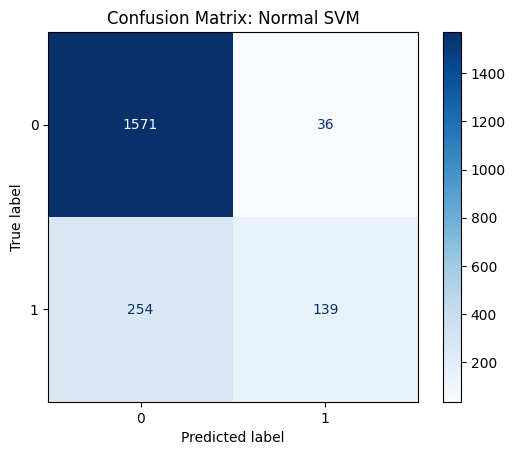

In [52]:
# -----------------------------
# For Normal SVM
# -----------------------------
y_pred_normal = svm_normal.predict(X_test)
cm_normal = confusion_matrix(y_test, y_pred_normal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normal, display_labels=[0,1])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Normal SVM")


Text(0.5, 1.0, 'Confusion Matrix: Nyström + Linear SVM')

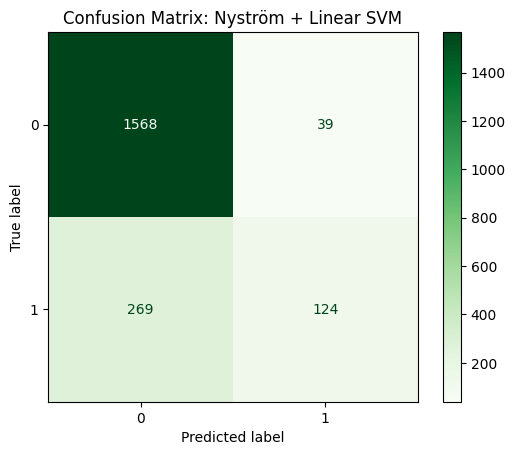

In [53]:
# -----------------------------
# For Nyström + Linear SVM
# -----------------------------
X_test_nys = nys.transform(X_test)  # transform test set
y_pred_nys = svm_nys.predict(X_test_nys)
cm_nys = confusion_matrix(y_test, y_pred_nys)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_nys, display_labels=[0,1])
disp.plot(cmap='Greens')
disp.ax_.set_title("Confusion Matrix: Nyström + Linear SVM")


In [54]:
# -----------------------------
# Normal SVM
# -----------------------------
y_pred_normal = svm_normal.predict(X_test)
print("=== Classification Report: Normal SVM ===")
print(classification_report(y_test, y_pred_normal, digits=4))

# -----------------------------
# Nyström + Linear SVM
# -----------------------------
X_test_nys = nys.transform(X_test)  # transform test set
y_pred_nys = svm_nys.predict(X_test_nys)
print("=== Classification Report: Nyström + Linear SVM ===")
print(classification_report(y_test, y_pred_nys, digits=4))


=== Classification Report: Normal SVM ===
              precision    recall  f1-score   support

           0     0.8608    0.9776    0.9155      1607
           1     0.7943    0.3537    0.4894       393

    accuracy                         0.8550      2000
   macro avg     0.8276    0.6656    0.7025      2000
weighted avg     0.8477    0.8550    0.8318      2000

=== Classification Report: Nyström + Linear SVM ===
              precision    recall  f1-score   support

           0     0.8536    0.9757    0.9106      1607
           1     0.7607    0.3155    0.4460       393

    accuracy                         0.8460      2000
   macro avg     0.8072    0.6456    0.6783      2000
weighted avg     0.8353    0.8460    0.8193      2000



Nyström transform time: 0.1531 seconds
SGDClassifier training time: 0.1643 seconds
Prediction time: 0.0012 seconds
Total runtime: 0.3187 seconds

Accuracy: 0.8590

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8707    0.9683    0.9169      1607
           1     0.7606    0.4122    0.5347       393

    accuracy                         0.8590      2000
   macro avg     0.8156    0.6902    0.7258      2000
weighted avg     0.8491    0.8590    0.8418      2000



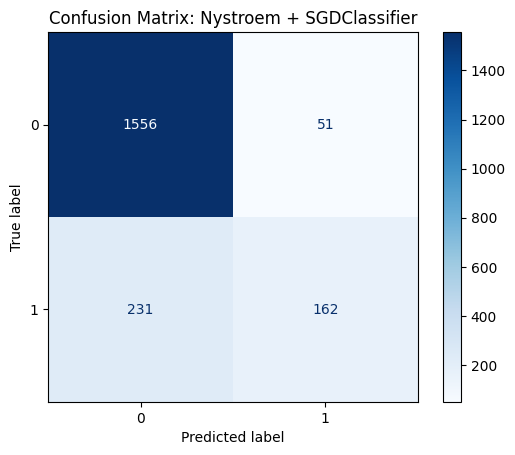

In [57]:
# -----------------------------
# 1. Nyström Transformation Time
# -----------------------------
start_nys = time.time()
nys = Nystroem(
    kernel="rbf",
    gamma=0.05,
    n_components=200,
    random_state=42
)
X_train_nys = nys.fit_transform(X_train)
X_test_nys = nys.transform(X_test)
end_nys = time.time()
nys_time = end_nys - start_nys
print(f"Nyström transform time: {nys_time:.4f} seconds")

# -----------------------------
# 2. SGDClassifier Training Time
# -----------------------------
sgd_clf = SGDClassifier(
    loss="hinge",
    alpha=0.0001,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

start_train = time.time()
sgd_clf.fit(X_train_nys, y_train)
end_train = time.time()
train_time = end_train - start_train
print(f"SGDClassifier training time: {train_time:.4f} seconds")

# -----------------------------
# 3. Prediction Time (Optional)
# -----------------------------
start_pred = time.time()
y_pred = sgd_clf.predict(X_test_nys)
end_pred = time.time()
pred_time = end_pred - start_pred
print(f"Prediction time: {pred_time:.4f} seconds")

# -----------------------------
# 4. Total Time
# -----------------------------
total_time = nys_time + train_time + pred_time
print(f"Total runtime: {total_time:.4f} seconds")

# -----------------------------
# 5. Evaluate Model
# -----------------------------
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Nystroem + SGDClassifier")
plt.show()

In [58]:
# -----------------------------
# File path
# -----------------------------
report_file = "svm_nystroem_report.txt"

# -----------------------------
# Report content
# -----------------------------
report_content = """
Performance and Speed Report: SVM Models with Nyström Kernel Approximation

1. Overview
This experiment compares the performance and runtime of three SVM-based models on a synthetic classification dataset with 5000 samples and 50 features:

1. Normal SVM (RBF kernel)
2. Nyström + Linear SVM
3. Nyström + SGDClassifier (hinge loss)

2. Speed Comparison
Method                        Transform Time (s)    Fit Time (s)    Total Time (s)
Normal SVM (RBF)              —                    1.7792          1.7792
Nyström + Linear SVM           1.0571               18.4670         19.5241
Nyström + SGDClassifier        0.1531               0.1643          0.3187

3. Accuracy and Classification Metrics

3.1 Nyström + SGDClassifier
Accuracy: 0.8590
Class 0: Precision=0.8707, Recall=0.9683, F1=0.9169, Support=1607
Class 1: Precision=0.7606, Recall=0.4122, F1=0.5347, Support=393
Macro Avg: Precision=0.8156, Recall=0.6902, F1=0.7258
Weighted Avg: Precision=0.8491, Recall=0.8590, F1=0.8418

3.2 Normal SVM (RBF)
Accuracy: 0.8550
Class 0: Precision=0.8608, Recall=0.9776, F1=0.9155, Support=1607
Class 1: Precision=0.7943, Recall=0.3537, F1=0.4894, Support=393
Macro Avg: Precision=0.8276, Recall=0.6656, F1=0.7025
Weighted Avg: Precision=0.8477, Recall=0.8550, F1=0.8318

3.3 Nyström + Linear SVM
Accuracy: 0.8460
Class 0: Precision=0.8536, Recall=0.9757, F1=0.9106, Support=1607
Class 1: Precision=0.7607, Recall=0.3155, F1=0.4460, Support=393
Macro Avg: Precision=0.8072, Recall=0.6456, F1=0.6783
Weighted Avg: Precision=0.8353, Recall=0.8460, F1=0.8193

4. Summary and Insights
- Nyström + SGDClassifier is extremely fast (0.3187s total) and accurate (0.8590), suitable for large datasets.
- Normal SVM is fast for small datasets (~1.779s) and slightly less accurate for minority classes.
- Nyström + Linear SVM is slower on medium datasets and slightly lower accuracy due to kernel approximation.

5. Recommendations
- Use SGDClassifier with Nystroem for datasets with >50,000 samples or high-dimensional features.
- Apply class weighting or oversampling to improve recall for minority classes.
- Tune n_components and gamma for best trade-off between accuracy and speed.
"""

# -----------------------------
# Write to file
# -----------------------------
with open(report_file, "w") as f:
    f.write(report_content)

print(f"Report saved to {report_file}")


Report saved to svm_nystroem_report.txt
